# Nutriocinal Interference Evaluation in Pacients with S.O.P
Name(s) : Vítor Corrêa Silva

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn .model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from  sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn import svm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from string import Template
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

In [86]:
class Process:
    def __init__(self, path : str = 'data/staged/full_treated_data.json') -> None:
        self.df_raw = pd.read_json(path)
        self.df_raw.columns = [str(x).strip() for x in self.df_raw.columns.to_list()]
        self.instantiate_models()
        self.df_raw['ID_VOLUNT'] = self.df_raw['ID_VOLUNT'].apply(lambda x : 0 if x == 2 else 1)
        self.fix_smart()
        self.fix_diet()
        self.fix_mental()
        print({
            'Controle Hígio': {
                'Original' : 1,
                'Atualizado' : 1
            },
            'SOP' : {
                'Original' : 2,
                'Atualizado' : 0
            }
        })
    
    @staticmethod
    def drop_empty(df: pd.DataFrame)->pd.DataFrame:
        return df[(df != 999).all(axis=1)].reset_index(drop=True).copy()
    
    @property
    def SOP_data(self) -> pd.DataFrame:
        return self.df_raw[self.df_raw['ID_VOLUNT']== 0].reset_index(drop=True).copy()
    
    @property
    def condition_quest_data(self) -> dict:
        target = 'ID_VOLUNT'
        cols = [
        # 'IDADE'
        ]
        for i in range(1,24):
            cols.append(f'Q_{i}_T1')
        cols.append("TOTAl_T1")
        all_cols = cols
        all_cols.append(target)
        df = self.drop_empty(self.df_raw[all_cols])
        return {
            "X" : df[cols].drop(columns=target),
            "Y" : df[target]
            }
    
    def interference_valuation_data(self, target):
        df = self.SOP_data.copy()
        df = df.drop(columns=[
            "ID_PROJ", 
            "ID_VOLUNT",
            'IMC2_CLASS',
            'CC_T2_CLAS',
            'RCQ_T2_CLAS',
            'RCE_T2_CLAS',
            'CP_T2_CLAS',
            'CB_T2_CLAS',
            'CB_T2_ADEQUA',
            'IMC1_CLASS',
            'CC_T1_CLAS',
            'RCQ_T1_CLAS',
            'RCE_T1_CLAS',
            'CP_T1_CLAS',
            'CB_T1_CLAS',
            'CB_T1_ADEQUA',
            # Diet
            'PESO_T2',
            'VCT_T2',
            'CHO_G_T2',
            'CHO_%_T2',
            'PTN_G_T2',
            'PTN_%_T2',
            'LIP_G_T2',
            'LIP_%_T2',
            'COLESTEROL_T2',
            'ADEQ_COLES_T2',
            'G_SAT_T2',
            'ADEQ_G_SAT_T2',
            'VCT_T1',
            'CHO_G_T1',
            'CHO_%_T1',
            'PTN_G_T1',
            'PTN_%_T1',
            'LIP_G_T1',
            'LIP_%_T1',
            'COLESTEROL_T1',
            'ADEQ_COLES_T1',
            'G_SAT_T1',
            'ADEQ_G_SAT_T1',
            'T1_PONT_TOTAL',
            'T1_PONT_A',
            'T1_PONT_D',
            'T2_PONT_TOTAL',
            'T2_PONT_A',
            'T2_PONT_D',
            "IDADE",
            'PESO_T1',
            'IMC_T1',
            'IMC1_CLASS',
            'CC_T1',
            'CC_T1_CLAS',
            'CQ_T1',
            'RCQ_T1',
            'RCQ_T1_CLAS',
            'RCE_T1',
            'RCE_T1_CLAS',
            'CP_T1',
            'CP_T1_CLAS',
            'CB_T1',
            'CB_T1_ADEQUA',
            'CB_T1_CLAS',
            'ALTURA'
            ])
        q_cols ={}
        for i in range(1,24):
            q_cols[f'Q_{i}_T1'] = f'Q_{i}_T2'
        q_cols["TOTAl_T1"] = "TOTAl_T2"
        for key_1, key_2 in q_cols.items():
            df[key_1] = df[key_1].replace(999, 0.0)
            mask = df[key_1] != 999
            df.loc[mask & (df[key_2] == 999), key_2] = df.loc[mask, key_1]
        df.to_excel("test.xlsx")
        return {
            "Y": df[target],
            "X": df.drop(columns=self.targets)
        }
        
    
    def instantiate_models(self):
        self.models ={
            'lr_clf' : LogisticRegression(random_state=0),
            'rf_clf' : RandomForestClassifier(random_state=0),
            'gb_clf' : GaussianNB(),
            'knn_clf' : neighbors.KNeighborsClassifier(),
            'svm_clf' : svm.SVC(kernel='linear', probability = True),
            'svm_rbf_clf' : svm.SVC(kernel='rbf', probability = True),
            'svm_sig_clf' : svm.SVC(kernel='sigmoid', probability = True),
            'xgb_clf' : XGBClassifier(),
            'gbc_clf' : GradientBoostingClassifier(random_state=0),
            'dt_clf' : DecisionTreeClassifier(random_state=0)}
    
    def rank_features(self, data : dict):
        X = data['X']
        y = data['Y']
        ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)

        importance = np.abs(ridge.coef_)
        feature_names = np.array(X.columns)

        # Sort the features by their importance
        indices = np.argsort(importance)[::-1]
        top_feature_indices = indices[:]
        try:
            top_features = feature_names[top_feature_indices[:23]]
            top_importance = importance[top_feature_indices[:23]]
        except:
            top_features = feature_names[top_feature_indices]
            top_importance = importance[top_feature_indices]
        plt.clf()
        plt.barh(top_features, top_importance)
        plt.xlabel('Importance')
        plt.title("Feature Importances via Coefficients")
        plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.savefig(f'images/Data_Behavior/Feature_Importance.png')
        return top_features.tolist()
    
    def select_best_model_ridge(self, data):
        best_models = {}
        data
        X_train,X_test,Y_train,Y_test = train_test_split(data['X'],data['Y'], test_size=0.3, random_state=0)
        features_rank = self.rank_features(data)

        best_model = {'Name': None, 'Score':0.0, 'variables': []}
        
        for N in range(4,len(data['X'].columns)):
            self.instantiate_models()
            for model_name, model in self.models.items():
                trained = model.fit(X_train[features_rank[:N]],Y_train)
                score = trained.score(X_test[features_rank[:N]], Y_test)
                if score > best_model['Score']:
                    best_model['Name'] = model_name
                    best_model['Score'] = score
                    best_model['variables'] = features_rank[:N]
                    best_model['Model'] = model
        self.confusion_matrix(best_model, data)
        # self.plot_auc_from_dict(best_model, data
        #                          )
        self.plot_auc_from_dict(best_model, {"X": X_test, "Y" : Y_test} )
        return best_model
    
    @staticmethod
    def confusion_matrix(best_model, data):
        model = best_model['Model']
        features = best_model['variables']
        name = best_model['Name']
        y_pred = model.predict(data['X'][features])
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            confusion_matrix(data['Y'], y_pred), 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=np.unique(data['Y']), 
            yticklabels=np.unique(data['Y'])
            )
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {name}')
        plt.savefig(f'images/Data_Behavior/Model_Behavior/Status_Classifier/Confusion_Matrix_{name}')
    
    def fix_smart(self):
        cols = ["SEGUIU_METAS_1","SEGUIU_METAS2","SEGUIU_METAS3"]
        for col in cols:
            self.df_raw[col]=self.df_raw[col].apply(lambda x: 0.0 if (x == 999) or np.isnan(x) else x )

    def fix_mental(self):
        mental_t2 = ['T2_PONT_TOTAL','T2_PONT_A','T2_PONT_D']
        mental_t1 = [x.replace("T2","T1") for x in mental_t2]
        for key_1, key_2 in zip(mental_t1, mental_t2):
            mask = self.df_raw[key_1] != 999
            self.df_raw.loc[mask & (self.df_raw[key_2] == 999), key_2] = self.df_raw.loc[mask, key_1]

    def fix_diet(self):
        diet_t2 = [
            'VCT_T2','CHO_G_T2','CHO_%_T2','PTN_G_T2',
            'PTN_%_T2','LIP_G_T2','LIP_%_T2','COLESTEROL_T2',
            'ADEQ_COLES_T2','G_SAT_T2','ADEQ_G_SAT_T2'
        ]
        diet_t1 = [x.replace("T2","T1") for x in diet_t2]
        for key_1, key_2 in zip(diet_t1, diet_t2):
            mask = self.df_raw[key_1] != 999
            self.df_raw.loc[mask & (self.df_raw[key_2] == 999), key_2] = self.df_raw.loc[mask, key_1]

    def delta_targets(self):
        pairs = {
            'IMC_T2' : 'IMC_T1',
            'CC_T2' : 'CC_T1',
            'CQ_T2' : 'CQ_T1',
            'RCQ_T2' : 'RCQ_T1',
            'RCE_T2' : 'RCE_T1',
            'CP_T2' : 'CP_T1',
            'CB_T2' : 'CB_T1',
        }
        new_target_cols = []
        for t_2, t_1 in pairs.items():
            new_col = t_2.replace("_T2","_D")
            new_target_cols.append(new_col)
            self.df_raw[new_col] = self.df_raw[t_2] - self.df_raw[t_1]
            self.df_raw[new_col] = self.df_raw[new_col].apply(lambda x : 1 if x < 0 else 0 )
            self.df_raw = self.df_raw.drop(columns=t_2)
        self.targets = new_target_cols
        return new_target_cols
    
    @staticmethod
    def plot_auc_from_dict(model, data_dict):
        X_test = data_dict['X']
        y_test = data_dict['Y']
        name = model['Name']
        # Make predictions on the test set
        try:
            y_prob = model['Model'].predict_proba(X_test[model["variables"]])[:, 1]
        except:
            y_prob = model['Model']._predict_proba_lr(X_test[model["variables"]])[:, 1]
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) for {name}')
        plt.legend(loc="lower right")
        plt.show()


In [87]:
main = Process()

{'Controle Hígio': {'Original': 1, 'Atualizado': 1}, 'SOP': {'Original': 2, 'Atualizado': 0}}


In [88]:
main.delta_targets()

['IMC_D', 'CC_D', 'CQ_D', 'RCQ_D', 'RCE_D', 'CP_D', 'CB_D']

## Condition Evaluation

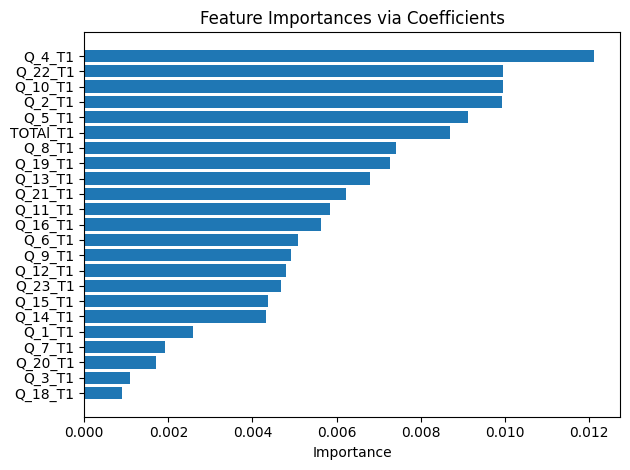

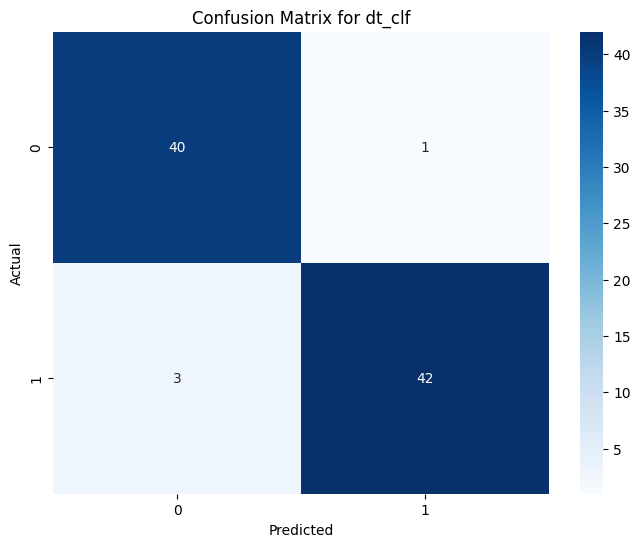

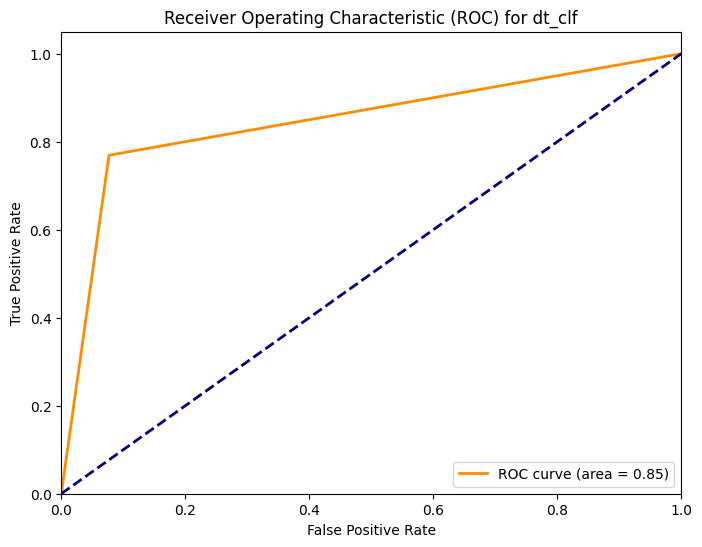

{'Name': 'dt_clf', 'Score': 0.8461538461538461, 'variables': ['Q_4_T1', 'Q_22_T1', 'Q_10_T1', 'Q_2_T1', 'Q_5_T1', 'TOTAl_T1'], 'Model': DecisionTreeClassifier(random_state=0)}


In [89]:
best_model = main.select_best_model_ridge(main.condition_quest_data)
print(best_model)


## Antropometric Evaluation

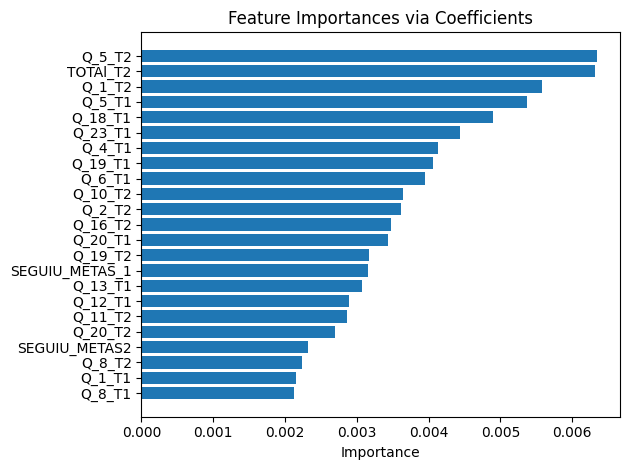

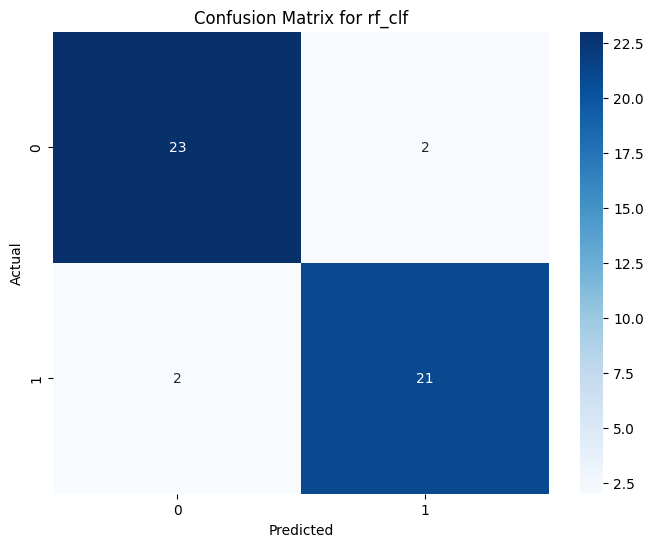

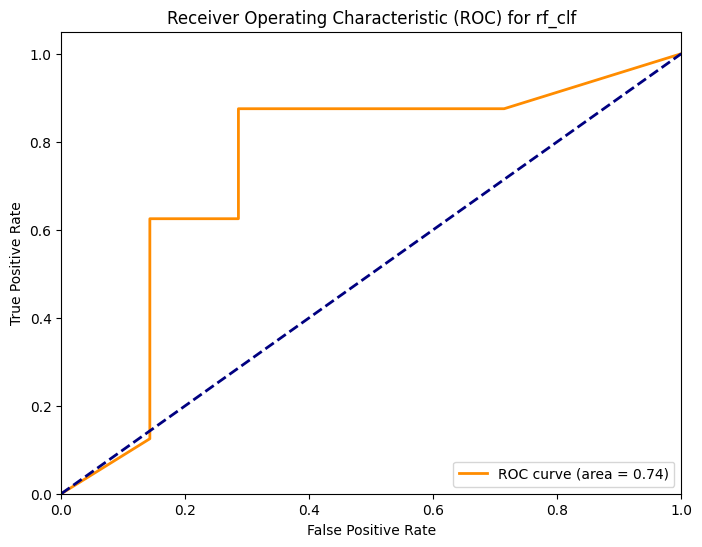

{'Name': 'rf_clf', 'Score': 0.7333333333333333, 'variables': ['Q_5_T2', 'TOTAl_T2', 'Q_1_T2', 'Q_5_T1'], 'Model': RandomForestClassifier(random_state=0)}


In [90]:
best_model = main.select_best_model_ridge(main.interference_valuation_data('IMC_D'))
print(best_model)

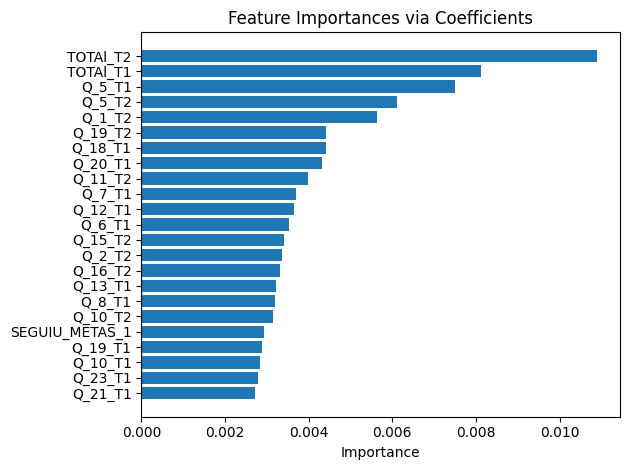

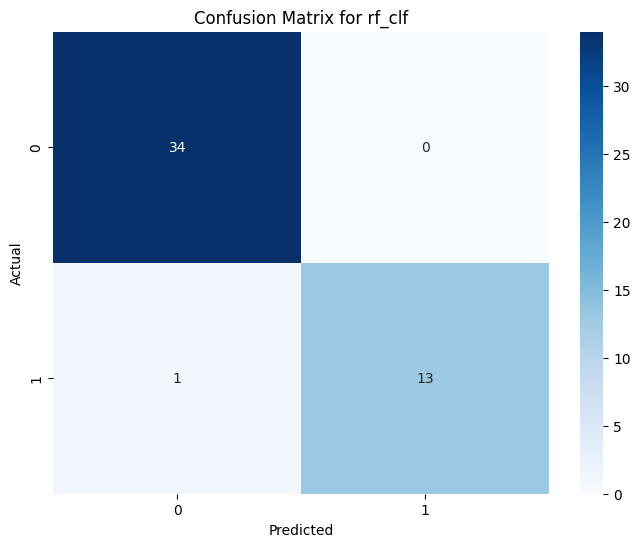

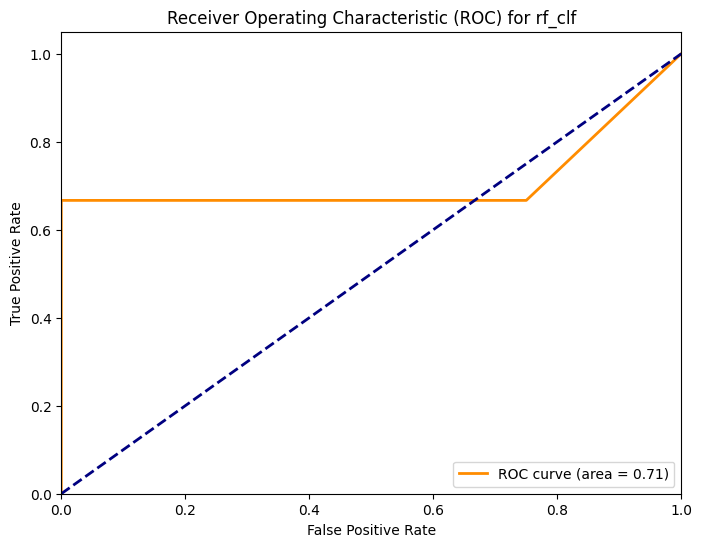

{'Name': 'rf_clf', 'Score': 0.9333333333333333, 'variables': ['TOTAl_T2', 'TOTAl_T1', 'Q_5_T1', 'Q_5_T2'], 'Model': RandomForestClassifier(random_state=0)}


In [91]:
best_model = main.select_best_model_ridge(main.interference_valuation_data('CC_D'))
print(best_model)

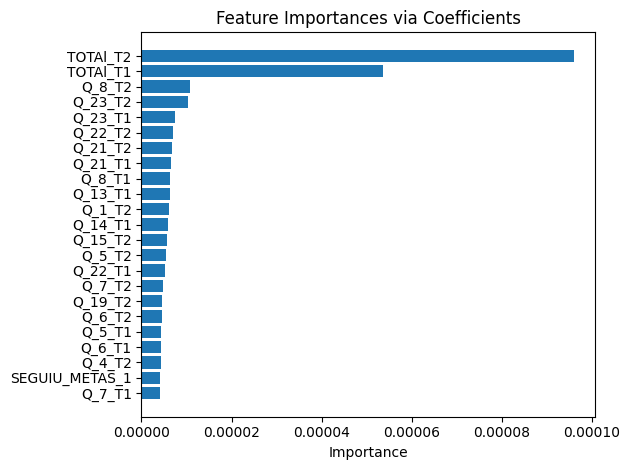

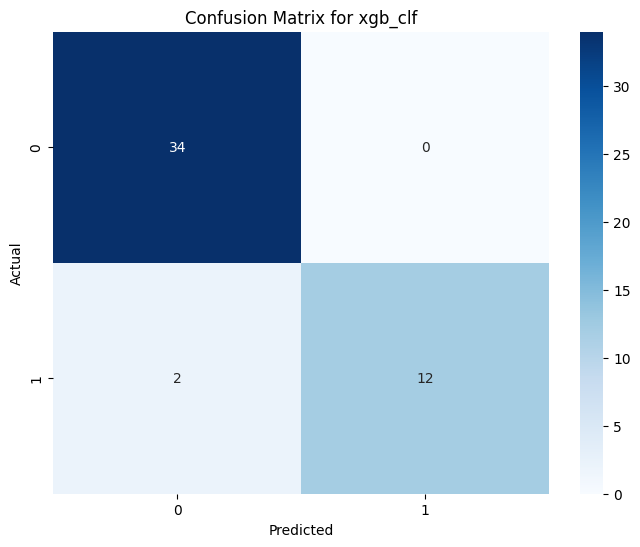

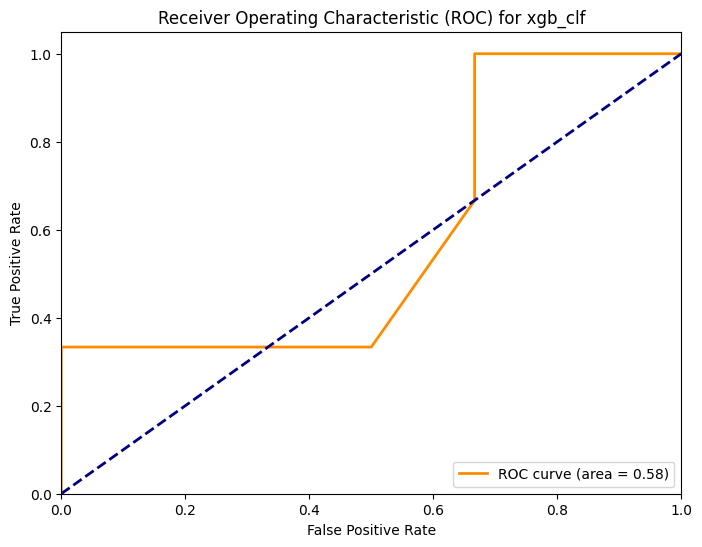

{'Name': 'xgb_clf', 'Score': 0.8666666666666667, 'variables': ['TOTAl_T2', 'TOTAl_T1', 'Q_8_T2', 'Q_23_T2', 'Q_23_T1', 'Q_22_T2', 'Q_21_T2', 'Q_21_T1', 'Q_8_T1', 'Q_13_T1'], 'Model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}


In [92]:
best_model = main.select_best_model_ridge(main.interference_valuation_data('CQ_D'))
print(best_model)

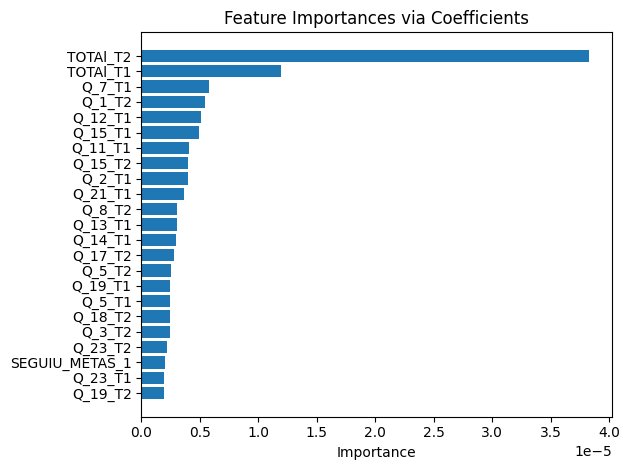

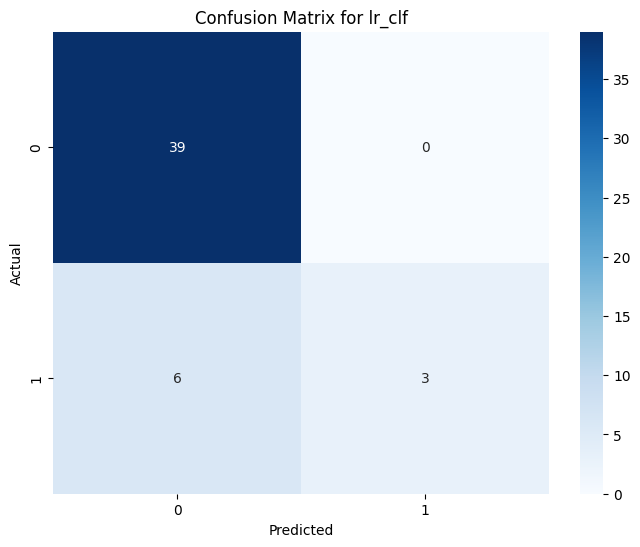

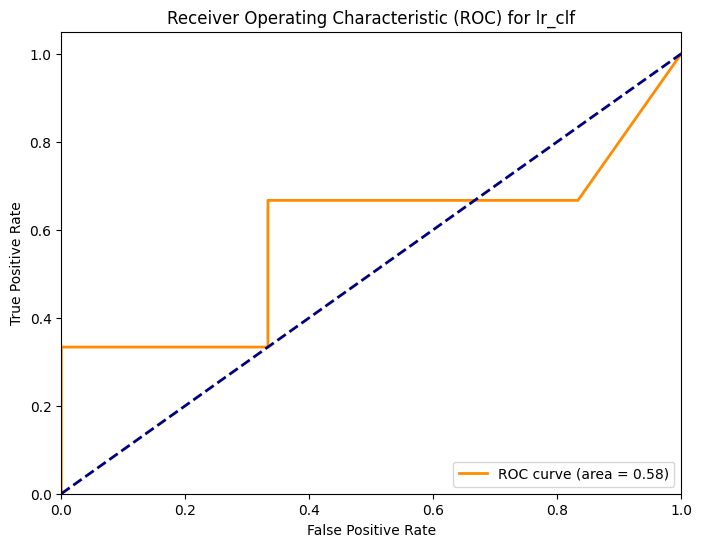

{'Name': 'lr_clf', 'Score': 0.8666666666666667, 'variables': ['TOTAl_T2', 'TOTAl_T1', 'Q_7_T1', 'Q_1_T2', 'Q_12_T1'], 'Model': LogisticRegression(random_state=0)}


In [93]:
best_model = main.select_best_model_ridge(main.interference_valuation_data('RCQ_D'))
print(best_model)

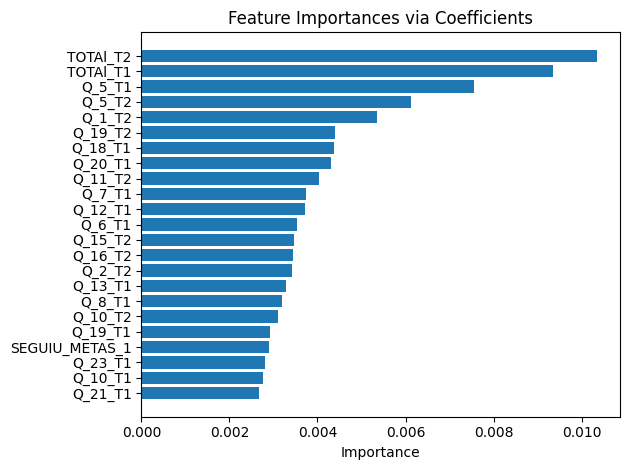

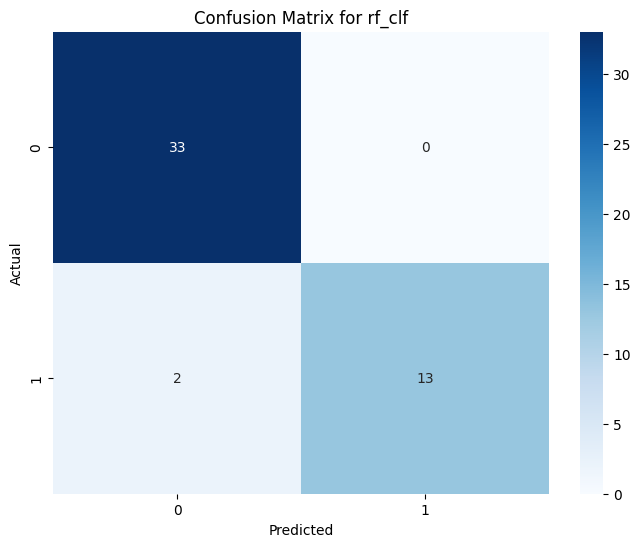

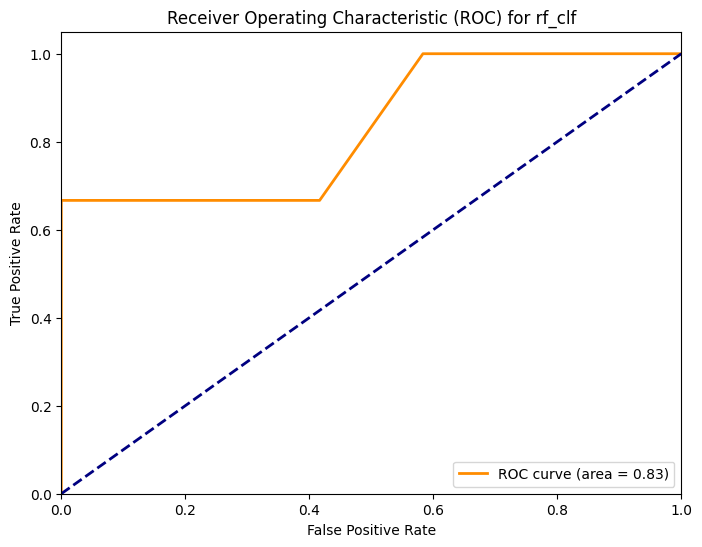

{'Name': 'rf_clf', 'Score': 0.9333333333333333, 'variables': ['TOTAl_T2', 'TOTAl_T1', 'Q_5_T1', 'Q_5_T2'], 'Model': RandomForestClassifier(random_state=0)}


In [94]:
best_model = main.select_best_model_ridge(main.interference_valuation_data('RCE_D'))
print(best_model)

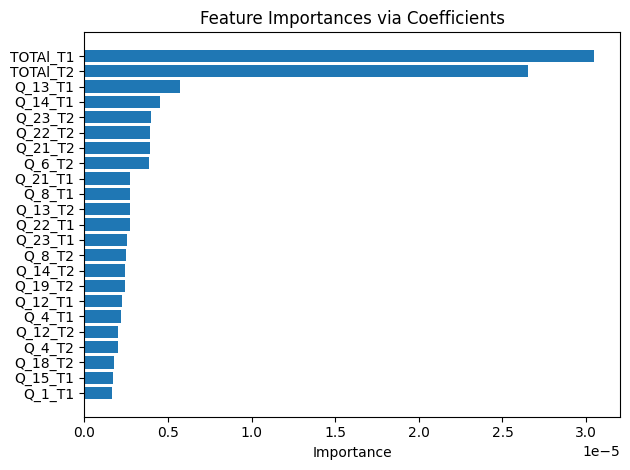

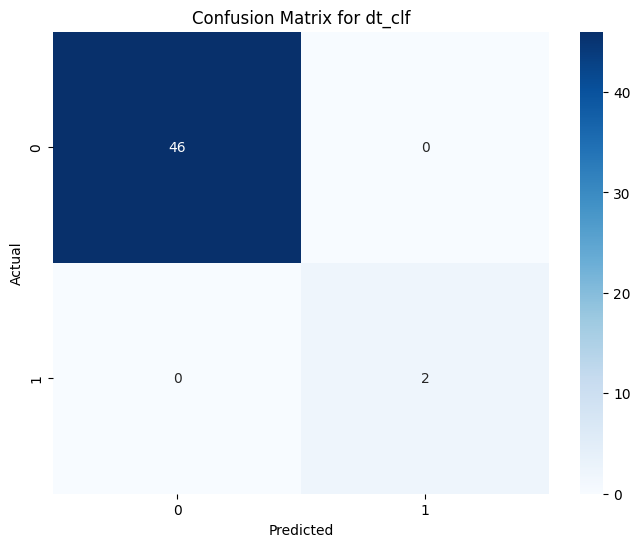

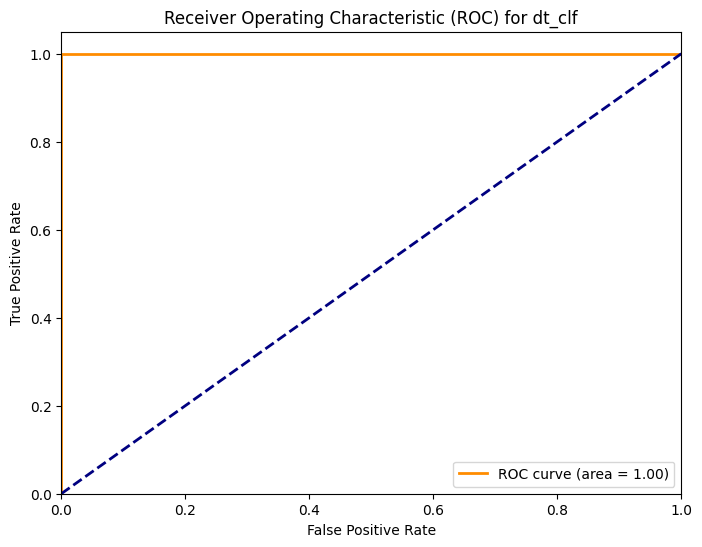

{'Name': 'dt_clf', 'Score': 1.0, 'variables': ['TOTAl_T1', 'TOTAl_T2', 'Q_13_T1', 'Q_14_T1', 'Q_23_T2'], 'Model': DecisionTreeClassifier(random_state=0)}


In [95]:
best_model = main.select_best_model_ridge(main.interference_valuation_data('CP_D'))
print(best_model)

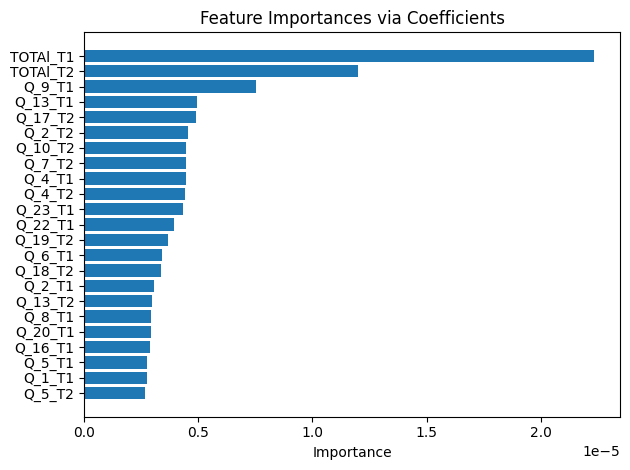

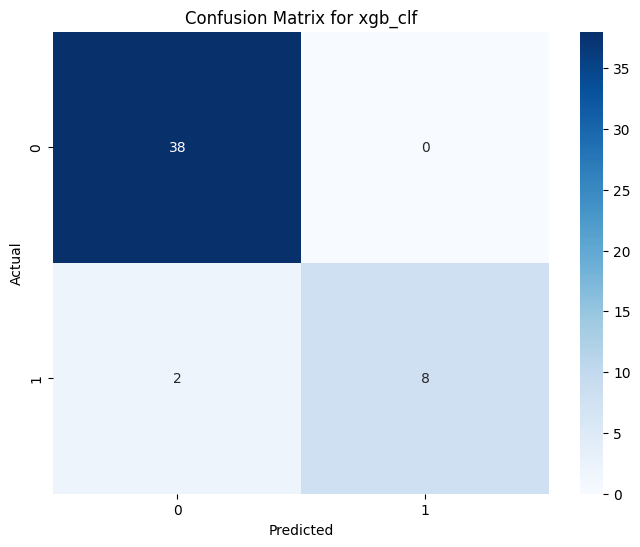

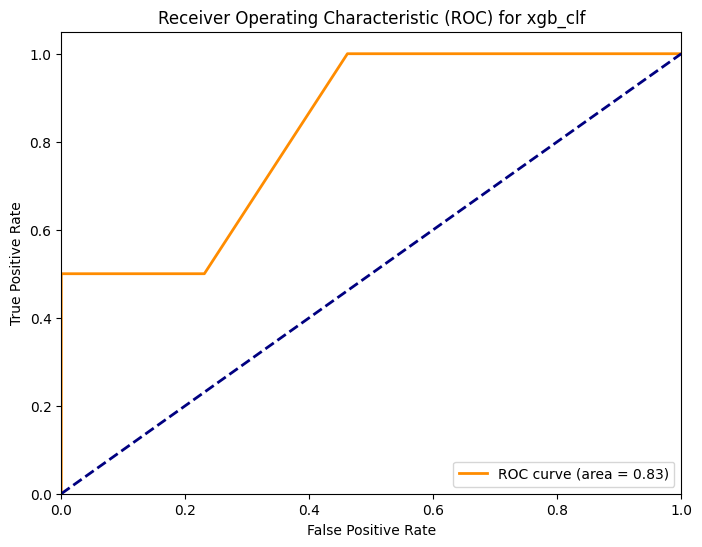

{'Name': 'xgb_clf', 'Score': 0.9333333333333333, 'variables': ['TOTAl_T1', 'TOTAl_T2', 'Q_9_T1', 'Q_13_T1'], 'Model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}


In [96]:
best_model = main.select_best_model_ridge(main.interference_valuation_data('CB_D'))
print(best_model)